In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import imageio
from shutil import copy2, rmtree
from IPython.display import Video, clear_output
plt.style.use('seaborn-whitegrid')

In [2]:
data_path = r'C:\Users\jupol\Desktop\TensorTut\covid\legacyCovidMexico'
data_dir = os.listdir(data_path)

In [3]:
sufx_dict = {
    'Deaths': 'Casos_Diarios_Estado_Nacional_Defunciones_2020',
    'Confirmed': 'Casos_Diarios_Estado_Nacional_Confirmados_2020',
    'Suspicious': 'Casos_Diarios_Estado_Nacional_Sospechosos_2020',
    'Negatives': 'Casos_Diarios_Estado_Nacional_Negativos_2020'
}

def clean_nan(array):
    if type(array) == list:
        array = np.asarray(array) 
    not_nan_array = ~ np.isnan(array)
    return array[not_nan_array]

In [4]:
def make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim):
    
    if not os.path.exists(f'plots/{state}/cummulative/{dtype}'):
        os.makedirs(f'plots/{state}/cummulative/{dtype}')
        
    if not os.path.exists(f'plots/{state}/discrete/{dtype}'):
        os.makedirs(f'plots/{state}/discrete/{dtype}')
        
    data = pd.read_csv(os.path.join(data_path,file))
    data = data[data['nombre'] == state]
    dates = pd.to_datetime(data.columns[3:], dayfirst=True)
    
    plot_data = []
                       
    for day in index:
        try:
            plot_data.append(data[str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
        except:
            plot_data.append(np.nan)
    
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Daily {dtype} Cases for Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_day+(max_day*0.3))
    plt.xlim(trim,len(plot_index))
    plt.xticks(rotation=70)
    plt.bar(plot_index,plot_data, label = f'Number of {dtype} Cases: {max(clean_nan(np.array(plot_data)))}')
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.legend(loc=0,fontsize=20)
    plt.savefig(f'plots/{state}/discrete/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')
    
    cummulative_record = []
    last_valid = int()
    for i in plot_data:

        if len(cummulative_record) == 0:
            if not np.isnan(i):
                cummulative_record.append(i)
                last_valid = i
            else:
                cummulative_record.append(np.nan)
                last_valid = 0
        else:
            if not np.isnan(i):
                cummulative_record.append(i+last_valid)
                last_valid += i

            else:
                cummulative_record.append(np.nan)
            
    print(file)
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Cummulative register of {dtype} Cases by Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_cummulative+(max_cummulative*0.3))
    plt.xticks(rotation=70)
    plt.xlim(trim,len(plot_index))
    plt.plot(plot_index,cummulative_record, label=dtype+': '+str(max(clean_nan(cummulative_record))))
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.fill_between(plot_index, cummulative_record, color='b', alpha=.2)
    plt.legend(loc=0, fontsize=18)
    plt.savefig(f'plots/{state}/cummulative/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')
    
    print(f'Plots of {dtype} ready for day: {calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}')

In [5]:
def get_indexes(sufx, data_dir, state):

    newest_date = max(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in data_dir if date.startswith(sufx)]))
    latest_date = min(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in data_dir if date.startswith(sufx)]))

    newest_date = pd.read_csv(os.path.join( data_path, sufx + str(newest_date)[-14:-12]+str(newest_date)[-11:-9]+'.csv') )
    latest_date = pd.read_csv(os.path.join( data_path, sufx + str(latest_date)[-14:-12]+str(latest_date)[-11:-9]+'.csv') )

    max_day = max(newest_date[newest_date['nombre'] == state].values[0][3:])
    max_cummulative = sum(newest_date[newest_date['nombre'] == state].values[0][3:])
    
    index = pd.date_range(start= pd.to_datetime(latest_date.columns[3], dayfirst=True), end = pd.to_datetime(newest_date.columns[-1], dayfirst=True))
    plot_index = [calendar.month_name[int(str(x)[5:-12])] + ' / ' + str(x)[8:-9]  for x in index]
        
    return index, plot_index, max_day, max_cummulative

In [6]:
def make_animation(data_dir, dtype, state, trim=0):
    
    sufx = sufx_dict[dtype]
    index, plot_index, max_day, max_cummulative = get_indexes(sufx, data_dir, state)
    files = [file for file in data_dir if file.startswith(sufx)]
    
    for file in files:
        make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim)
        clear_output(wait=True)

    plots  = [x[:-4] for x in os.listdir(f'plots/{state}/cummulative/{dtype}')]
    max_date = str(max(pd.to_datetime(plots)))[:10]
    
    for _ in range(30):
        copy2(f'plots/{state}/cummulative/{dtype}/{max_date}.jpg', f'plots/{state}/cummulative/{dtype}/{max_date}_{_}.jpg')
        copy2(f'plots/{state}/discrete/{dtype}/{max_date}.jpg', f'plots/{state}/discrete/{dtype}/{max_date}_{_}.jpg')
    
    if not os.path.exists(f'results/{state}'):
        os.makedirs(f'results/{state}')
    
    cum_images = []
    
    for filename in os.listdir(f'plots/{state}/cummulative/{dtype}'):
        cum_images.append(imageio.imread(os.path.join(f'plots/{state}/cummulative/{dtype}',filename)))
    imageio.mimsave(f'results/{state}/{dtype}_cummulative_{state}.mp4', cum_images)
    
    dis_images = []
    
    for filename in os.listdir(f'plots/{state}/discrete/{dtype}'):
        dis_images.append(imageio.imread(os.path.join(f'plots/{state}/discrete/{dtype}',filename)))
    imageio.mimsave(f'results/{state}/{dtype}_discrete_{state}.mp4', dis_images)
    
    rmtree('plots')

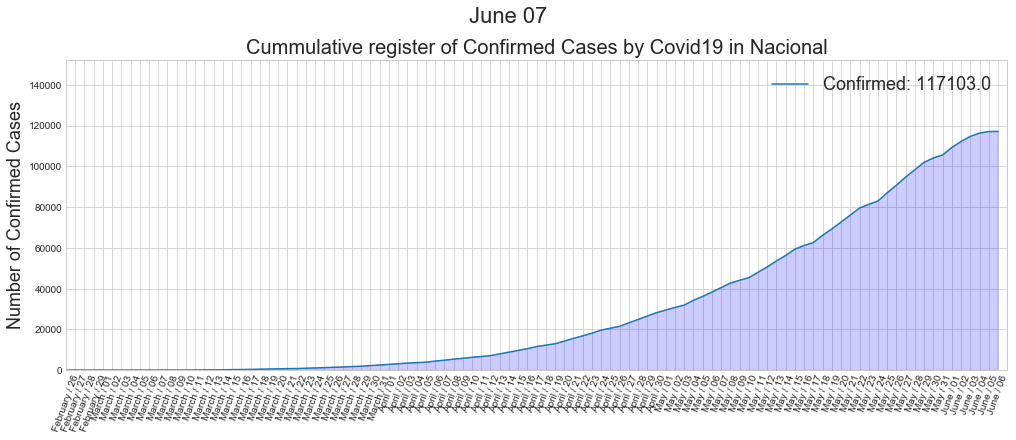

In [7]:
make_animation(data_dir = data_dir,
               dtype     = 'Confirmed',
               state    = 'Nacional',
               trim=50)

In [8]:
b = np.array([[5,6,6],[5,4,2],[7,8,9]])
c = ['foo','oioi','tuyy']

In [9]:
for i in plot_data:
    if not np.isnan(i):
        print('lkashdkjahs')
    else:
        print('EKSSEE')

NameError: name 'plot_data' is not defined

In [ ]:
b[:,1]

In [ ]:
d = {}
for ind,i in enumerate(c):
    d[i]= b[:,ind]

In [ ]:
d

In [ ]:
e = pd.DataFrame(data=d)

In [ ]:
e

In [ ]:
{'Column1': data[:, 0], 'Column2': data[:, 1]})